# DenseVariational Layers

> In this post, we will cover prior distribution over the weight and obtain posterior distribution. We will implement feed-forward network using the DenseVariational Layer. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/denseVariational_layer.png

## Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfpl = tfp.layers

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Overview

### Feed-forward network with probabilistic layer output

```python
model = Sequential([
    Dense(16, activation='relu', input_shape=(8, )),
    Dense(2),
    tfpl.IndependentNormal(1)
])

model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true))
model.fit(X_train, y_train, epochs=200)
```

this model can generator point estimates for these dense layer weights and biases. But in order to capture the epistemic uncertainty, it would like instead to learn posterior distribution over these parameters.

### Prior and Posterior Distribution
```python

# kernel_size: the number of parameters in the dense weight matrix
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    # Independent Normal Distribution
    return lambda t: tdf.Independent(tfd.Normal(loc=tf.zeros(n, dtype=dtype),
                                                scale=1),
                                     reinterpreted_batch_ndims=1)

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n)
    ])
```

### Distribution model instead of point estimates
```python
model = Sequential([
    # Requires posterior and prior distribution
    # Add kl_weight for weight regularization
    tfpl.DenseVariational(16, posterior, prior, kl_weight=1/N, activation='relu', input_shape=(8, )),
    tfpl.DenseVariational(2, posterior, prior, kl_weight=1/N),
    tfpl.IndependentNormal(1)
])
```

### Maximizing Evidence Lower Bound (ELBO)

$$ q = q(w \vert \theta) \\
\mathbb{E}_{w \sim q}[\log p(D \vert w)] - KL[q \vert \vert p] $$

-$q$ : posterior distribution over all the weights of model.

-$w$ : vector over all the model weights, which is random variable.

-$\theta$ : parameters that parameterize this posterior

First term of ELBO is the expected log likelihood of the data, and the second term is the KL divergence between posterior and the prior. this is for regularizing the posterior. Assuming IID condition, we can re-express like this,

$$ \begin{aligned} & \mathbb{E}_{w \sim q}[\log p(D \vert w)] - KL[q \vert \vert p] \\
   & = \sum_i \mathbb{E}_{w \sim q}[ \log p(D_i \vert w)] - KL[q \vert \vert p] \end{aligned} $$
   
For a minibatch,

$$ \frac{N}{B} \times \sum_i \mathbb{E}_{w \sim q}[ \log p(D_i \vert w)] - KL[q \vert \vert p] $$

where $N$ is total size of data, and $B$ is the size of minibatch.

We can address the sample loss like this,

$$ \frac{1}{B}\times \sum_i \mathbb{E}_{w \sim q}[ \log p(D_i \vert w)] - \frac{1}{N} KL[q \vert \vert p] $$

### Use kl divergence analytic solution

```python
model = Sequential([
    # Requires posterior and prior distribution
    # Add kl_weight for weight regularization
    tfpl.DenseVariational(16, posterior, prior, kl_weight=1/N, kl_use_exact=True,
                          activation='relu', input_shape=(8, )),
    tfpl.DenseVariational(2, posterior, prior, kl_weight=1/N, kl_use_exact=True),
    tfpl.IndependentNormal(1)
])
```
Using `kl_use_exact` argument, this layer analytically compute the kl divergence for both prior and posterior. Otherwise, it will be estimated from the posterior distribution.

## Tutorial

### Create linear data with Gaussian noise

The data you'll be working with is the same as you used before:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed. We'll be running a Bayesian linear regression on this data.

In [3]:
# Use the same data as before -- create and plot 100 data points

X_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = X_train + 0.3 * np.random.randn(100)[:, np.newaxis]

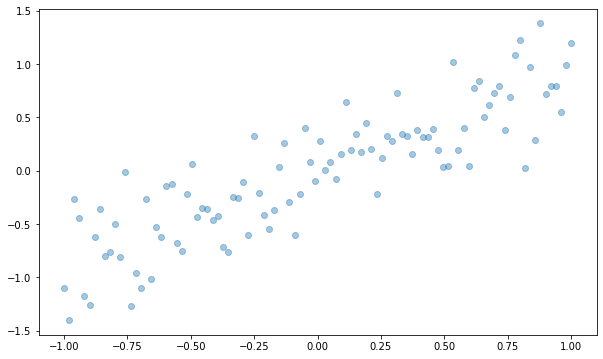

In [4]:
plt.scatter(X_train, y_train, alpha=0.4)
plt.show()

### Create the prior and posterior distribution for model weights

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

In [6]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))),
    ])
    return prior_model

In [7]:
# Define the variational posterior weight distribution -- Multivariate Gaussian

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

### Aside: analytical posterior

In this tutorial, we're using a variational posterior because, in most settings, it's not possible to derive an analytical one. However, in this simple setting, it is possible. Specifically, running a Bayesian linear regression on $x_i$ and $y_i$ with $i=1, \ldots, n$ and a unit Gaussian prior on both $\alpha$ and $\beta$:

$$
y_i = \alpha + \beta x_i + \epsilon_i, \quad 
\epsilon_i \sim N(0, \sigma^2), \quad 
\alpha \sim N(0, 1), \quad 
\beta \sim N(0, 1)
$$

gives a multivariate Gaussian posterior on $\alpha$ and $\beta$:

$$
\begin{pmatrix}
\alpha \\
\beta
\end{pmatrix}
\sim
N(\mathbf{\mu}, \mathbf{\Sigma})
$$

where

$$ \mathbf{\mu} = \mathbf{\Sigma} 
\begin{pmatrix}
\hat{n} \bar{y} \\
\hat{n} \overline{xy}
\end{pmatrix},
\quad
\mathbf{\Sigma} = 
\frac{1}{(\hat{n} + 1)(\hat{n} \overline{x^2} + 1) - \hat{n}^2 \bar{x}^2}
\begin{pmatrix}
\hat{n} \overline{x^2} + 1 & -\hat{n} \bar{x} \\
-\hat{n} \bar{x} & \hat{n} + 1
\end{pmatrix}.
$$

In the above, $\hat{n} = \frac{n}{\sigma^2}$ and $\bar{t} = \frac{1}{n}\sum_{i=1}^n t_i$ for any $t$. In general, however, it's not possible to determine the analytical form for the posterior. For example, in models with a hidden layer with nonlinear activation function, the analytical posterior cannot be determined in general, and variational methods as below are useful.

### Create the model with `DenseVariational` layers

In [10]:
# Create linear regression model with weight uncertainty: weights are
# distributed according to posterior (and, indirectly, prior) distribution

model = Sequential([
    tfpl.DenseVariational(input_shape=(1, ), units=1, 
                          make_prior_fn=prior, make_posterior_fn=posterior, 
                          kl_weight=1/X_train.shape[0], kl_use_exact=True),
])

model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


### Train model and inspect

In [11]:
# Fit the model, just like a deterministic linear regression

model.fit(X_train, y_train, epochs=500, verbose=False)

In [12]:
# Check out the paramters of the prior and posterior distribution

dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)

print('Prior mean:     ', model_prior.mean().numpy())
print('Prior Variance: ', model_prior.variance().numpy())
print('Posterior mean: ', model_posterior.mean().numpy())
print('Posterior variance:', model_posterior.covariance().numpy()[0])
print('                   ', model_posterior.covariance().numpy()[1])

Prior mean:      [0. 0.]
Prior Variance:  [1. 1.]
Posterior mean:  [0.8741125  0.01051628]
Posterior variance: [ 0.01692707 -0.00069193]
                    [-0.00069193  0.00545705]


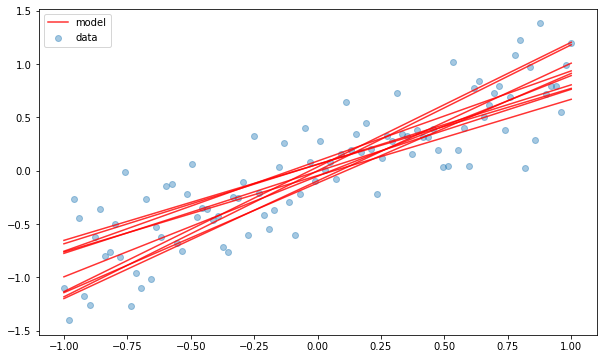

In [13]:
# Plot an ensemble of linear regressions, with weights sampled from
# the posterior distribution

plt.scatter(X_train, y_train, alpha=0.4, label='data')
for i in range(10):
    y_model = model(X_train)
    if i == 0:
        plt.plot(X_train, y_model, color='red', alpha=0.8, label='model')
    else:
        plt.plot(X_train, y_model, color='red', alpha=0.8)
plt.legend(loc='best')
plt.show()

### Explore the effect of sample size

In [14]:
# Create two datasets, one with 1000 points, another with 100
X_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train_1000 = X_train_1000 + 0.3 * np.random.randn(1000)[:, np.newaxis]

X_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train_100 = X_train_100 + 0.3 * np.random.randn(100)[:, np.newaxis]

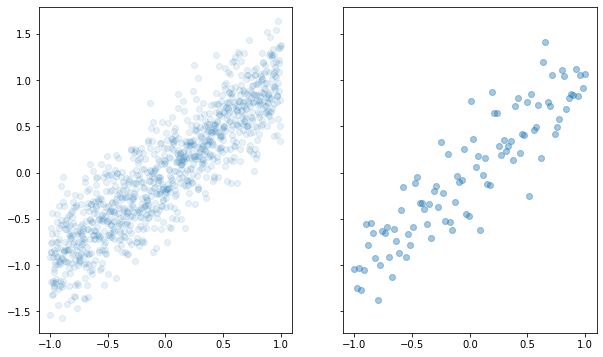

In [15]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].scatter(X_train_1000, y_train_1000, alpha=0.1)
ax[1].scatter(X_train_100, y_train_100, alpha=0.4)
plt.show()

In [16]:
# Train a model on each dataset

model_1000 = Sequential([
    tfpl.DenseVariational(input_shape=(1, ),
                          units=1,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/1000)
])

model_100 = Sequential([
    tfpl.DenseVariational(input_shape=(1, ),
                          units=1,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/100)
])

In [17]:
model_1000.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))

model_1000.fit(X_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(X_train_100, y_train_100, epochs=50, verbose=False)

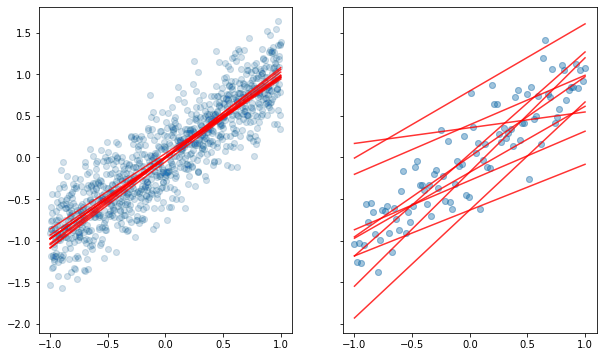

In [18]:
# Plot an ensemble of linear regressions from each model

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
for _ in range(10):
    y_model_1000 = model_1000(X_train_1000)
    ax[0].scatter(X_train_1000, y_train_1000, color='C0', alpha=0.02)
    ax[0].plot(X_train_1000, y_model_1000, color='red', alpha=0.8)
    
    y_model_100 = model_100(X_train_100)
    ax[1].scatter(X_train_100, y_train_100, color='C0', alpha=0.05)
    ax[1].plot(X_train_100, y_model_100, color='red', alpha=0.8)
plt.show()

### Put it all together: nonlinear probabilistic regression with weight uncertainty

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

In [19]:
# Create and plot 1000 data points
X_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(X_train, 3) + 0.1 * (2 + X_train) * np.random.randn(1000)[:, np.newaxis]

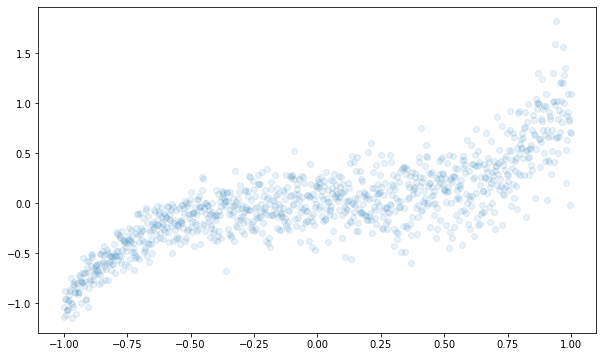

In [20]:
plt.scatter(X_train, y_train, alpha=0.1)
plt.show()

In [22]:
# Create probabilistic regression with one hidden layer weight uncertainty

model = Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1, ),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0]),
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_3 (DenseVa (None, 8)                 152       
_________________________________________________________________
dense_variational_4 (DenseVa (None, 2)                 189       
_________________________________________________________________
independent_normal (Independ multiple                  0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Train the model
model.fit(X_train, y_train, epochs=1000, verbose=False)
model.evaluate(X_train, y_train)

32/32 [==============================] - 0s 1ms/step - loss: -0.0391


-0.0390540175139904

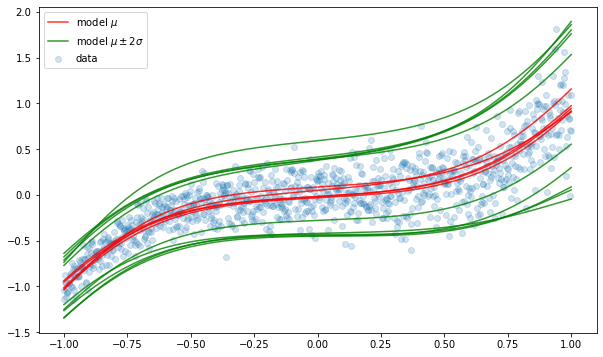

In [24]:
# Plot an ensemble of trained probabilistic regressions

plt.scatter(X_train, y_train, alpha=0.2, label='data')

for _ in range(5):
    y_model = model(X_train)
    y_hat = y_model.mean()
    y_hat_m2std = y_hat - 2 * y_model.stddev()
    y_hat_p2std = y_hat + 2 * y_model.stddev()
    
    if _ == 0:
        plt.plot(X_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(X_train, y_hat_m2std, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(X_train, y_hat_p2std, color='green', alpha=0.8)
    else:
        plt.plot(X_train, y_hat, color='red', alpha=0.8)
        plt.plot(X_train, y_hat_m2std, color='green', alpha=0.8)
        plt.plot(X_train, y_hat_p2std, color='green', alpha=0.8)
plt.legend(loc='best')
plt.show()